<a href="https://colab.research.google.com/github/Ogunfool/Timeseries-Data-Analysis-and-Forecasting/blob/main/Timeseries_Data_Forecasting_With_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary libraries, Load data and Exploratory Data Analysis.

Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [56]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Load and plot data

In [ ]:
!wget https://lazyprogrammer.me/course_files/airline_passengers.csv

In [3]:
air_df = pd.read_csv('/content/airline_passengers.csv', index_col='Month', parse_dates=True)
air_df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


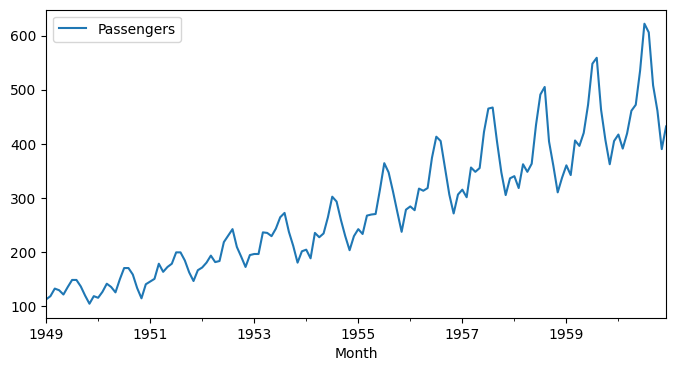

In [4]:
air_df.plot(figsize=(8,4));

In [ ]:
air_df.shape

(144, 1)

# Create Helper Functions

Timeseries data preparation: Scaling, Differencing, data indices for plotting and making supervised learning dataset

In [5]:
# Arguments: Univariate timeseries dataframe, prompt to difference or not, deepNet or not, col_name, and T.
# Return: Dataframe, x_train, x_test, y_train, y_test, train_idx, test_idx
def data_prep(df, T, D, Ntest, col_name='Passengers', difference=True, MNet=True, output_type='single'):
  X = []
  Y = []
  Tx = T
  Ty = Ntest

  # Log Data
  df['Log_'+col_name] = np.log(df[col_name])  # Log data

  # Difference or not
  if difference == True:
    df['Diff_Log_'+col_name] = df['Log_'+col_name].diff()  # Difference data
    series = df['Diff_Log_'+col_name].dropna().to_numpy()
  else:
    series = df['Log_'+col_name].to_numpy()


  # Make supervised data
  # make single output supervised dataset
  if output_type == 'single':
    for t in range(len(series) - T):
      x = series[t:t+T]
      X.append(x)
      y = series[t+T]
      Y.append(y)
    if MNet == True:
      X = np.array(X).reshape(-1, T)
      Y = np.array(Y)
    else:
      X = np.array(X).reshape(-1, T, D)
      Y = np.array(Y)

  else:
    # make multi-output supervised dataset
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    if MNet == True:
      X = np.array(X).reshape(-1, Tx)
      Y = np.array(Y).reshape(-1, Ty)
    else:
      X = np.array(X).reshape(-1, Tx, D)
      Y = np.array(Y).reshape(-1, Ty)


  return df, X, Y


Do Forecast: The wrong way/one-step forecast, Multi-step forecast and Multi-output forecast. Forecast steps: make predictions and un-differencing (one-step for train and test using the shifting method & multi-step forecast for test data using the cumulative sum method)

*   The data shape evolution: Orig_shape = 144; Diff_shape = 143; Sup_data_shape = 143 - P/T (10) = 133; data_split = 133-12 = 121.
*   So our X_train_pred = 121, X_test_pred = 12.



In [6]:
# One-step Forecast: This is not a correct way of making forecast, there is data leakage, the actua 
# The point of this is to plot the predicted X-train 
def one_step_forecast(df, model, T, X_train, X_test, train_idx, test_idx, col_name = 'Passengers'):
  train_idx[:T+1] = False # first T+1 values are not predictable
  X_train_pred = model.predict(X_train).flatten()
  X_test_pred = model.predict(X_test).flatten()

  # Shift logged data downwards to compute un-difference predictions
  df['ShiftLog_'+col_name] = df['Log_'+col_name].shift(1)
  prev = df['ShiftLog_'+col_name]

  # 1-step forecast
  df.loc[train_idx, '1step_train'] = prev[train_idx] + X_train_pred
  df.loc[test_idx, '1step_test'] = prev[test_idx] + X_test_pred

  # plot 1-step forecast
  df[['Log_Passengers', '1step_train', '1step_test']].plot(figsize=(15, 5));  

  return df, train_idx

In [7]:
# This is more concerned about making the right forecast and plotting it; i.e focus on X_test_pred
def multi_step_forecast(df, model, Ntest, D, X_test, test_idx, col_name='Passengers', MNet=True):
  # Last-known train value
  last_train = df.iloc[:-Ntest].iloc[-1]['Log_'+col_name]

  # multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = X_test[0]

  while len(multistep_predictions) < Ntest:
    if MNet == True:
      p = model.predict(last_x.reshape(1, -1))[0]
    else:
      p = model.predict(last_x.reshape(1, -1, D))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # Make multi-step forecast and put in dataframe
  forecast = last_train + np.cumsum(multistep_predictions)
  df.loc[test_idx, 'multistep'] = forecast

  # plot 1-step and multi-step forecast
  # df[['Log_Passengers', 'multistep', '1step_test']].plot(figsize=(15, 5));
  df[['Log_'+col_name, 'multistep']].plot(figsize=(15, 5));

  return df, forecast

# Use traditional ML algorithms to make forecast: One output: Single and Multi-step forecasts.

Declare Global Variables

In [ ]:
# Global Variables
T = 10
D = 1
Ntest = 12

train = air_df.iloc[:-Ntest]
test = air_df.iloc[-Ntest:]
# boolean series to index df rows
train_idx = air_df.index <= train.index[-1]
test_idx = air_df.index > train.index[-1]

print('train_idx.shape:',train_idx.shape, 'test_idx.shape:',test_idx.shape)

train_idx.shape: (144,) test_idx.shape: (144,)


In [ ]:
# Things to check after this function
airdf, X, Y = data_prep(air_df, T, D)
print("X.shape", X.shape, "Y.shape", Y.shape)
air_df.head()

X.shape (133, 10) Y.shape (133,)


,Passengers,Log_Passengers,Diff_Log_Passengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


Split dataset

In [ ]:
X_train, y_train = X[:-Ntest], Y[:-Ntest]
X_test, y_test = X[-Ntest:], Y[-Ntest:]
print("X_train.shape", X_train.shape, "Y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", y_test.shape)

X_train.shape (121, 10) Y_train.shape (121,)
X_test.shape (12, 10) Y_test.shape (12,)


Build ML Model 

In [ ]:
# Be it a sklearn or tensorflow model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

Make your model good: Make it learn, Minimize out of sample error.

In [ ]:
# Note, the only reason why we even had to have a test set at all in forecasting is to validate our model.
insample_score = model.score(X_train, y_train)
out_sample_score = model.score(X_test, y_test)
out_sample_score

0.6492870172668167

Make One-step forecast and plot - The aim is to see the predicted x_train compared to the actual logged data.

,Passengers,Log_Passengers,Diff_Log_Passengers,ShiftLog_Passengers,1step_train,1step_test
Month,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,0.052186,4.718499,NaN,NaN
1949-03-01,132,4.882802,0.112117,4.770685,NaN,NaN
1949-04-01,129,4.859812,-0.022990,4.882802,NaN,NaN
1949-05-01,121,4.795791,-0.064022,4.859812,NaN,NaN


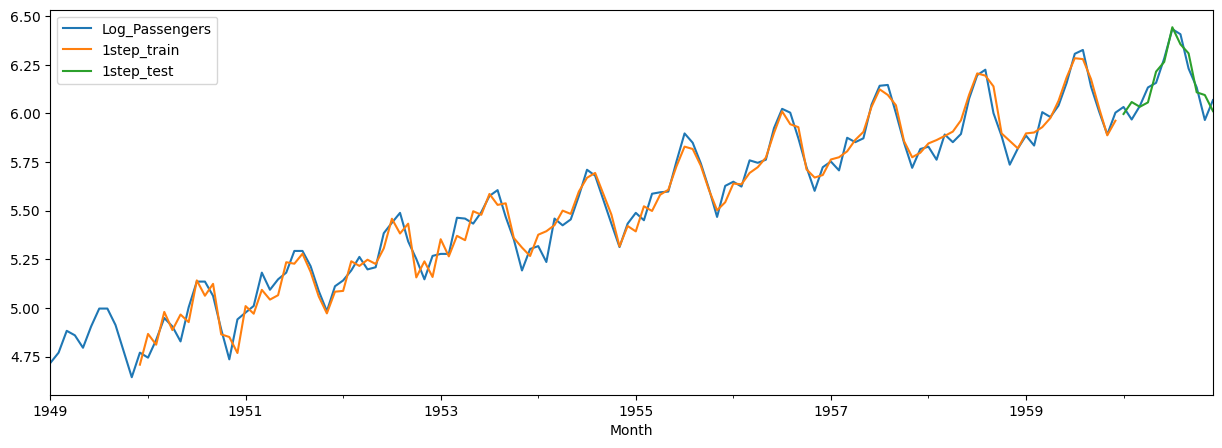

In [ ]:
air_df , train_idx = one_step_forecast(air_df, model, T, 
                                       X_train, X_test, train_idx, test_idx, col_name='Passengers')

air_df.head()

Make multi-step forecast and plot

,Passengers,Log_Passengers,Diff_Log_Passengers,ShiftLog_Passengers,1step_train,1step_test,multistep
Month,,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,0.052186,4.718499,NaN,NaN,NaN
1949-03-01,132,4.882802,0.112117,4.770685,NaN,NaN,NaN
1949-04-01,129,4.859812,-0.022990,4.882802,NaN,NaN,NaN
1949-05-01,121,4.795791,-0.064022,4.859812,NaN,NaN,NaN


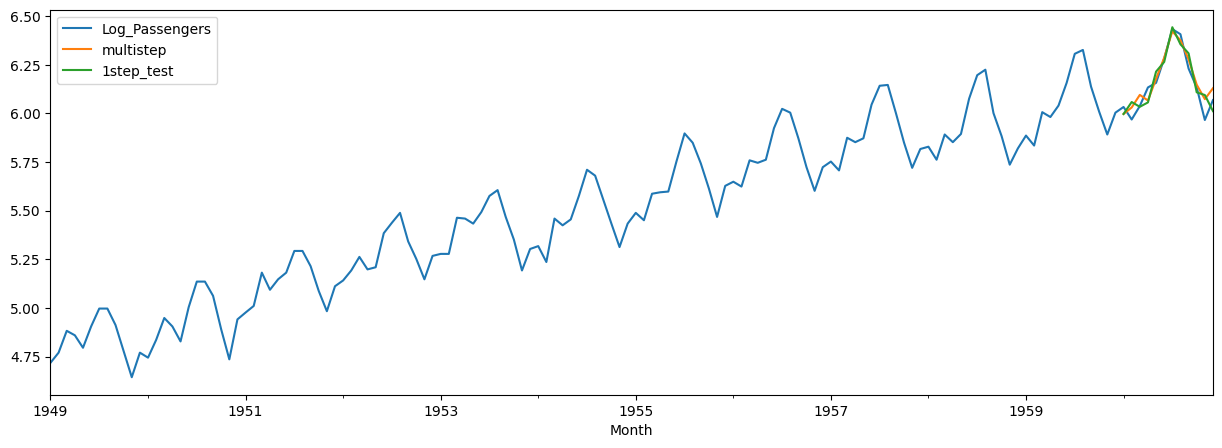

In [ ]:
air_df = multi_step_forecast(air_df, model, Ntest, D, X_test, test_idx, col_name='Passengers', MNet=True)
air_df.head()

# Perform Forecast/Call functions for multi-output/one-step prediction.

Using a multi-output method will require a different model entirely, the X and Y shapes will be different and the forecasting will also be a little diferent.

In [ ]:
# Things to check after this function
airdf, X, Y = data_prep(air_df, T, D, Ntest, output_type='multi')
print("X.shape", X.shape, "Y.shape", Y.shape)
air_df.head()

X.shape (122, 10) Y.shape (122, 12)


,Passengers,Log_Passengers,Diff_Log_Passengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


Split dataset

In [ ]:
# We are using just one test data
X_train, y_train = X[:-1], Y[:-1]
X_test, y_test = X[-1:], Y[-1:]
print("X_train.shape", X_train.shape, "Y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", y_test.shape)

X_train.shape (121, 10) Y_train.shape (121, 12)
X_test.shape (1, 10) Y_test.shape (1, 12)


Build ML Model 

In [ ]:
# Be it a sklearn or tensorflow model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

Make your model good: Make it learn, Minimize out of sample error.

In [ ]:
# Note, the only reason why we even had to have a test set at all in forecasting is to validate our model.
insample_score = model.score(X_train, y_train)
out_sample_score = model.score(X_test, y_test)
out_sample_score

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [ ]:
insample_score

0.8141637147930584

Make One-step forecast and plot - We have a single test set.

In [ ]:
X_test_pred = model.predict(X_test)
X_test_pred.shape

(1, 12)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test.flatten(), X_test_pred.flatten())

0.7867137438847718

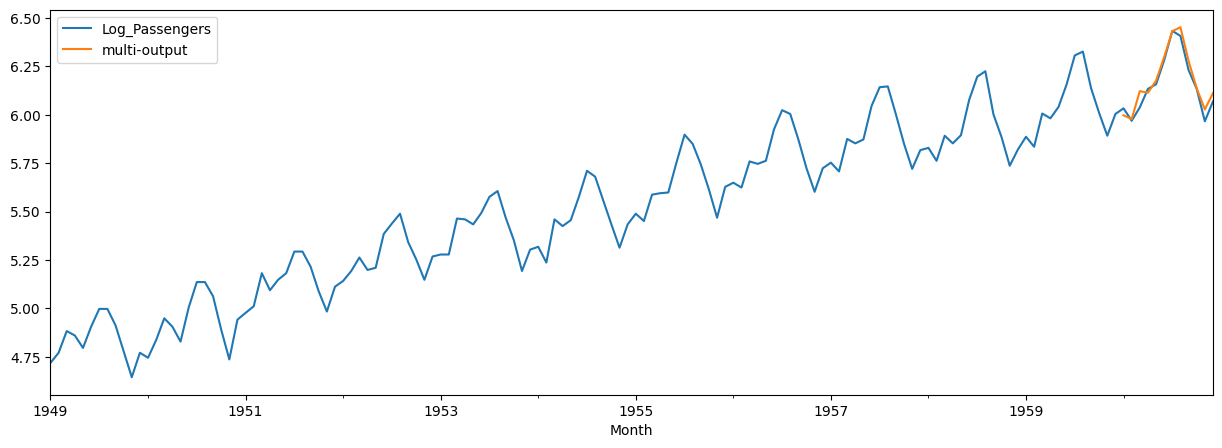

In [ ]:
last_train = air_df.iloc[:-Ntest].iloc[-1]['Log_Passengers']
# Make multi-step forecast and put in dataframe
air_df.loc[test_idx, 'multi-output'] = last_train + np.cumsum(X_test_pred.flatten())

# plot 1-step and multi-step forecast
air_df[['Log_Passengers', 'multi-output']].plot(figsize=(15, 5));

# Use Different Models and Result Evaluation - Linear regression, SVM and Random Forest.

Per model: Get R-score for multi-step and single step/multi-output forecast

In [66]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [ ]:
# Instantiate Models
SVM = SVR()
LR = LinearRegression()
RF = RandomForestRegressor()

In [ ]:
# Global Variables
T = 10
D = 1
Ntest = 12
col_name='Passengers'

train = air_df.iloc[:-Ntest]
test = air_df.iloc[-Ntest:]
# boolean series to index df rows
train_idx = air_df.index <= train.index[-1]
test_idx = air_df.index > train.index[-1]

print('train_idx.shape:',train_idx.shape, 'test_idx.shape:',test_idx.shape)

train_idx.shape: (144,) test_idx.shape: (144,)


X_train.shape (121, 10) Y_train.shape (121,)
X_test.shape (12, 10) Y_test.shape (12,)


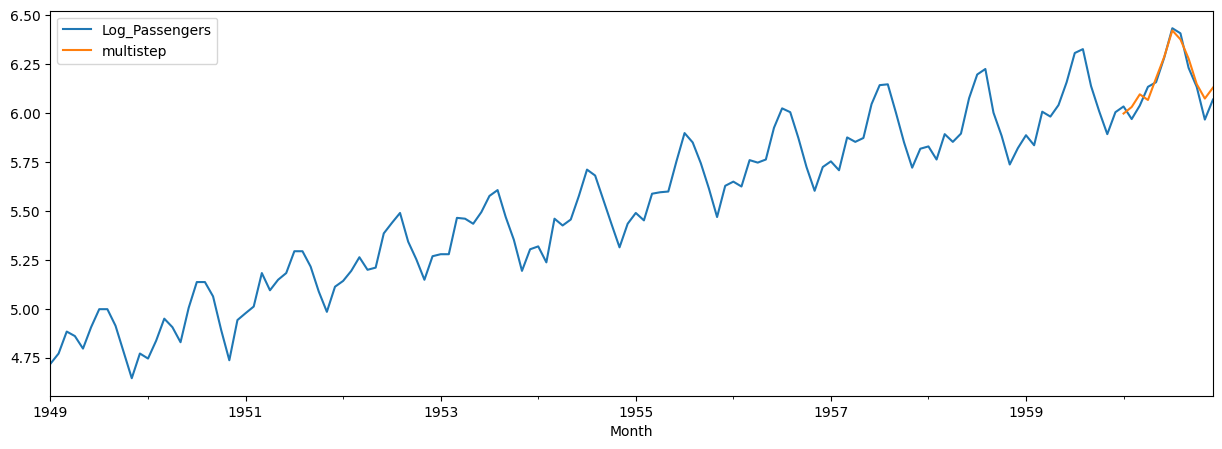

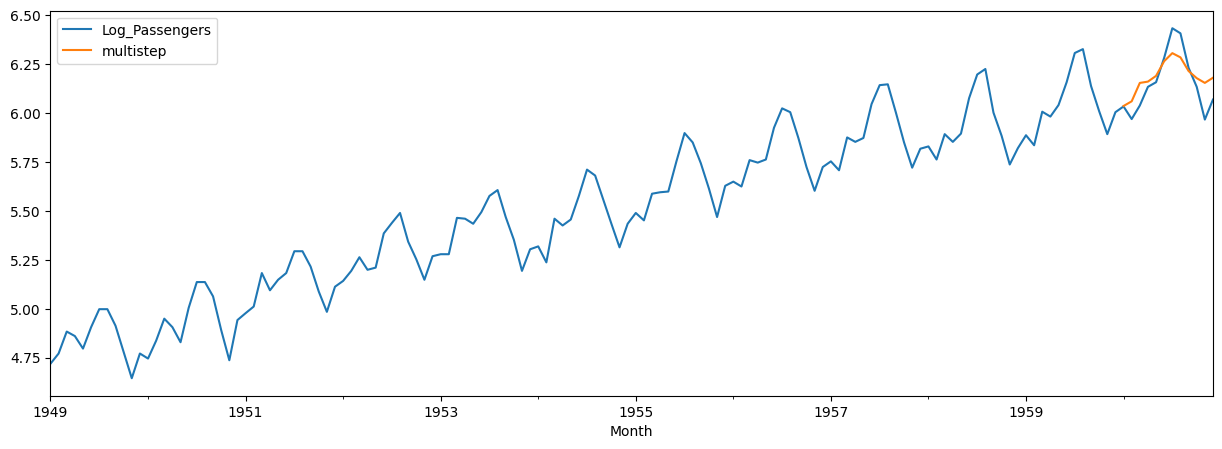

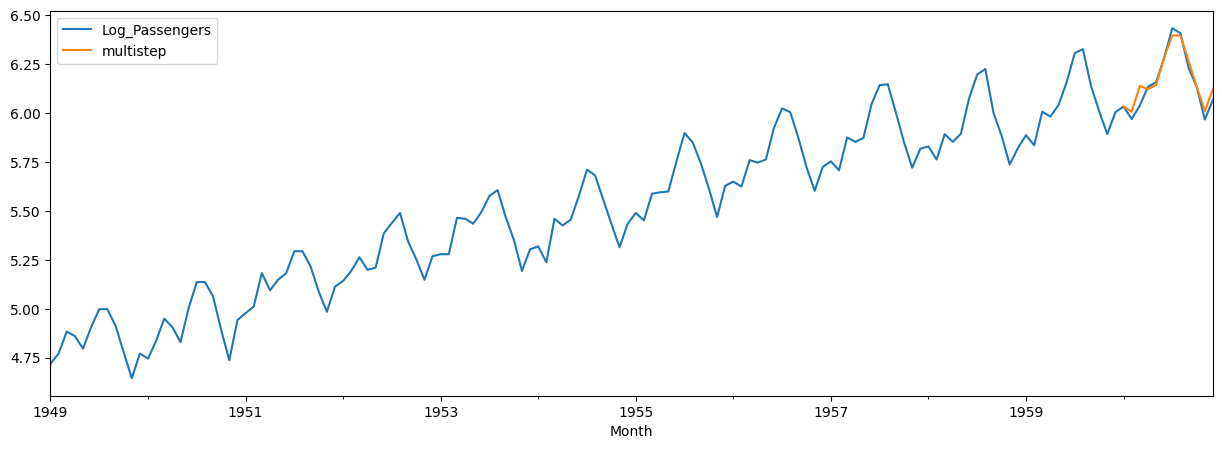

In [ ]:
# Multi-step prediction - MNet and DNets
# MNets
models = [LR, SVM, RF]
# models = [ANN, CNN, GRU, LSTM]
forecast_list = []
rscore_results_MM = []
MAPE_results_MM = []

# Data prep
airdf, X, Y = data_prep(air_df, T, D, Ntest, col_name='Passengers', difference=True, MNet=True, output_type='single')
# Train-test split
X_train, y_train = X[:-Ntest], Y[:-Ntest]
X_test, y_test = X[-Ntest:], Y[-Ntest:]
print("X_train.shape", X_train.shape, "Y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", y_test.shape)

for model in models:
  # Fit Model
  model.fit(X_train, y_train)

  # Multi-step test
  air_df, forecast = multi_step_forecast(air_df, model, Ntest, D, X_test, test_idx, col_name='Passengers', MNet=True)
  forecast_list.append(forecast)

  # Evaluate test data
  y_true = air_df.iloc[-Ntest:]['Log_'+col_name]
  mape = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multistep'])
  rscore = r2_score(y_true, air_df.loc[test_idx, 'multistep'])

  rscore_results_MM.append(rscore)
  MAPE_results_MM.append(mape)


In [ ]:
rscore_results

[0.8809949096887305, 0.6119302194044562, 0.9287184285097578]

In [ ]:
MAPE_results

[0.007109281288502536, 0.012149122102392764, 0.004731299904770553]

In [ ]:
air_df.head()

,Passengers,Log_Passengers,Diff_Log_Passengers,multistep
Month,,,,
1949-01-01,112,4.718499,NaN,NaN
1949-02-01,118,4.770685,0.052186,NaN
1949-03-01,132,4.882802,0.112117,NaN
1949-04-01,129,4.859812,-0.022990,NaN
1949-05-01,121,4.795791,-0.064022,NaN


# Using Deep Neural Networks Forecast - ANN, CNN, GRU and LSTM.

MULTI-OUTPUT FORECAST.

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras import losses, optimizers, layers, activations, regularizers
from keras.layers import Dense, Conv1D, LSTM, GRU, Input, Concatenate, MaxPool1D
from keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy, mean_squared_error
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.metrics import Accuracy, Recall, MeanSquaredError, MeanAbsolutePercentageError
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.pooling.global_max_pooling1d import GlobalMaxPooling1D
from keras.layers.reshaping.flatten import Flatten

In [22]:
# Let's create some helper functions for the training process (We are trying to select a model so, many models will be trained and they have similar execution configurations)
# Learning Rate Scheduler:
def lr_scheduler(STEPS_PER_EPOCH):
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)
  return lr_schedule

def get_optimizer(scheduler=None):
  if scheduler is None:
    return tf.keras.optimizers.Adam(learning_rate=0.001)
  return tf.keras.optimizers.Adam(lr_scheduler())

# def get_callbacks():
#   return [
#     tfdocs.modeling.EpochDots(),
#     tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=40),
#   ]

# Compile and fit
def compile(model, optimizer=None, scheduler=None,  loss=None, max_epochs=1000, STEPS_PER_EPOCH=1000):
  if optimizer is None:    # that is, i want to set Adam optimizer & learning rate to 0.001 by default or use a lr_scheduler function
    optimizer = get_optimizer()
  else:
    optimizer = optimizer

  if loss is None:
    loss = 'mse'
  else:
    loss = loss

  model.compile(optimizer=optimizer, loss=loss, metrics=[MeanAbsolutePercentageError()])

  return model


In [109]:
# Global Variables
T = 10
D = 1
K_s = 1
K_m = 12
Ntest = 12
Ntest_M = 1
col_name='Passengers'

train = air_df.iloc[:-Ntest]
test = air_df.iloc[-Ntest:]
# boolean series to index df rows
train_idx = air_df.index <= train.index[-1]
test_idx = air_df.index > train.index[-1]

print('train_idx.shape:',train_idx.shape, 'test_idx.shape:',test_idx.shape)

train_idx.shape: (144,) test_idx.shape: (144,)


In [63]:
# Build Models
# ANN - Seyi, note, ANN is comaptible with 2D data
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(K_m)(x)
model_ann = Model(i,x)

# CNN - 1D Conv
i = Input(shape=(T,D))
x = Conv1D(32, 3, activation='relu')(i)
x = MaxPool1D()(x)
x = Flatten()(x)
x = Dense(K_m)(x)
model_cnn = Model(i,x)

# GRU - Many to one
# By default, GRU and LSTM use tahn activation function, if you decide to use another activation function, it cannot be run on GPU
i = Input(shape=(T,D))
x = GRU(32)(i)
x = Dense(K_m)(x)
model_gru = Model(i,x)

# LSTM - Many to one with globalmaxpooling
i = Input(shape=(T,D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(K_m)(x)
model_lstm = Model(i,x)

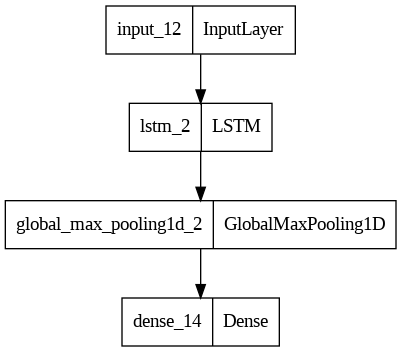

In [33]:
# Plot Model
tf.keras.utils.plot_model(model_lstm)

In [34]:
model_gru.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 gru_2 (GRU)                 (None, 16)                912       
                                                                 
 dense_13 (Dense)            (None, 12)                204       
                                                                 
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________


Using Deep Neural Networks for multi-output forecast - CNN, GRU and LSTM.

In [52]:
# Data prep
airdf, X, Y = data_prep(air_df, T, D, Ntest, col_name='Passengers', 
                        difference=True, MNet=False, output_type='multi')

# Train-test split (Single step, an extension can be multi-output-multi-step forecast)
X_train, y_train = X[:-Ntest_M], Y[:-Ntest_M]
X_test, y_test = X[-Ntest_M:], Y[-Ntest_M:]
print('X.shape', X.shape, 'Y.shape', Y.shape)
print("X_train.shape", X_train.shape, "Y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", y_test.shape)

X.shape (122, 10, 1) Y.shape (122, 12)
X_train.shape (121, 10, 1) Y_train.shape (121, 12)
X_test.shape (1, 10, 1) Y_test.shape (1, 12)


Compile and Fit Models - Multi-output (Input shape = NxTxD, Output shape = NxK)

Epoch 1/1000
4/4 - 1s - loss: 0.0125 - mean_absolute_percentage_error: 472228.2188 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 117.5948 - 863ms/epoch - 216ms/step
Epoch 2/1000
4/4 - 0s - loss: 0.0116 - mean_absolute_percentage_error: 425709.2812 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 107.7006 - 55ms/epoch - 14ms/step
Epoch 3/1000
4/4 - 0s - loss: 0.0110 - mean_absolute_percentage_error: 407914.7188 - val_loss: 0.0107 - val_mean_absolute_percentage_error: 99.7261 - 76ms/epoch - 19ms/step
Epoch 4/1000
4/4 - 0s - loss: 0.0105 - mean_absolute_percentage_error: 405793.5938 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 92.9154 - 62ms/epoch - 16ms/step
Epoch 5/1000
4/4 - 0s - loss: 0.0101 - mean_absolute_percentage_error: 422660.2500 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 89.1630 - 60ms/epoch - 15ms/step
Epoch 6/1000
4/4 - 0s - loss: 0.0097 - mean_absolute_percentage_error: 421553.4062 - val_loss: 0.0084 - val_mean_absolute_percentag

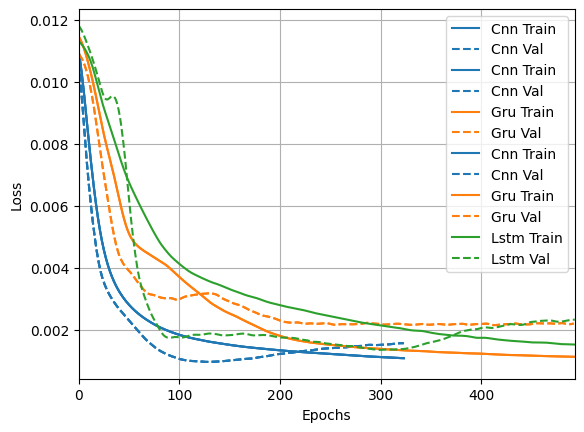

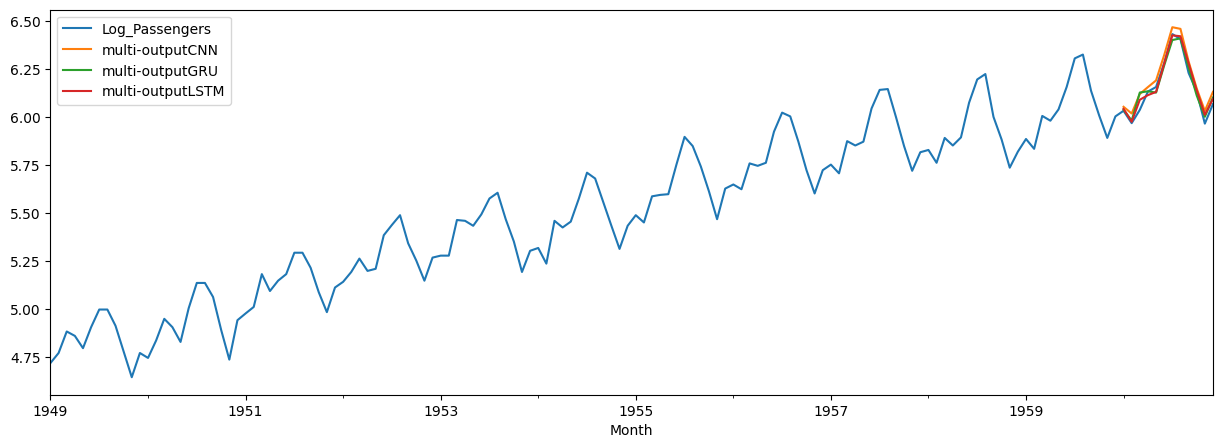

In [64]:
# DNets
history = {}
models = [model_cnn, model_gru, model_lstm]
names = ['CNN', 'GRU', 'LSTM']
last_train = air_df.iloc[:-Ntest].iloc[-1]['Log_Passengers']
for idx, name in enumerate(names):
  # instantiate call backs
  check_point = ModelCheckpoint('best_model_'+name+'.h5', monitor='val_loss', save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=200)

  # Compile Model
  model = compile(models[idx])

  # Fit Model
  history[name] = model.fit(X_train, y_train, epochs=1000, 
                      validation_data=(X_test, y_test),
                      callbacks=[check_point, early_stopping],
                      verbose=2)
  
  # Get best model from current model
  best_model = tf.keras.models.load_model('best_model_'+name+'.h5')

  # Predict Output and de-differencing
  X_test_pred = best_model.predict(X_test)
  air_df.loc[test_idx, 'multi-output'+name] = last_train + np.cumsum(X_test_pred.flatten())

  # Plot metric
  plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
  plotter.plot(history)

# plot 1-step forecast
air_df[['Log_Passengers', 'multi-outputCNN', 'multi-outputGRU', 'multi-outputLSTM']].plot(figsize=(15, 5));

Comment: To avoid retracing, try to convert the test and train data to a tf dataset first.

1.   At a glance at the predicted results from the model above, we can see than CNN overestimates the forecast a little, but generally, it looks like all the models did fairly well.
2.   Let's compare the MAPE scores of all the networks/models to see the one that pperforms best.



In [71]:
y_true = air_df.loc[test_idx, 'Log_Passengers']
mape_CNN = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-outputCNN'])
print('mape_CNN:', mape_CNN)
mape_GRU = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-outputGRU'])
print('mape_GRU:', mape_GRU)
mape_LSTM = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-outputLSTM'])
print('mape_LSTM:', mape_LSTM)

mape_CNN: 0.0074370869437521735
mape_GRU: 0.004156482848354078
mape_LSTM: 0.0036650270612509877


LSTM had the best result followed by GRU and CNN

Using Deep Neural Networks for multi-output forecast - ANN

In [72]:
# Data prep
airdf, X, Y = data_prep(air_df, T, D, Ntest, col_name='Passengers', 
                        difference=True, MNet=True, output_type='multi')

# Train-test split (Single step, an extension can be multi-output-multi-step forecast)
X_train, y_train = X[:-Ntest_M], Y[:-Ntest_M]
X_test, y_test = X[-Ntest_M:], Y[-Ntest_M:]
print('X.shape', X.shape, 'Y.shape', Y.shape)
print("X_train.shape", X_train.shape, "Y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", y_test.shape)

X.shape (122, 10) Y.shape (122, 12)
X_train.shape (121, 10) Y_train.shape (121, 12)
X_test.shape (1, 10) Y_test.shape (1, 12)


Compile and Fit Models - Multi-output (Input shape = NxTxD, Output shape = NxK)

Epoch 1/1000
4/4 - 1s - loss: 0.0153 - mean_absolute_percentage_error: 1098179.1250 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 121.3611 - 871ms/epoch - 218ms/step
Epoch 2/1000
4/4 - 0s - loss: 0.0144 - mean_absolute_percentage_error: 1010625.5000 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 118.8107 - 54ms/epoch - 13ms/step
Epoch 3/1000
4/4 - 0s - loss: 0.0136 - mean_absolute_percentage_error: 947981.5000 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 115.9982 - 53ms/epoch - 13ms/step
Epoch 4/1000
4/4 - 0s - loss: 0.0129 - mean_absolute_percentage_error: 903658.8125 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 113.1524 - 72ms/epoch - 18ms/step
Epoch 5/1000
4/4 - 0s - loss: 0.0123 - mean_absolute_percentage_error: 845476.6875 - val_loss: 0.0113 - val_mean_absolute_percentage_error: 110.9149 - 55ms/epoch - 14ms/step
Epoch 6/1000
4/4 - 0s - loss: 0.0118 - mean_absolute_percentage_error: 812189.0625 - val_loss: 0.0110 - val_mean_absolute_perc

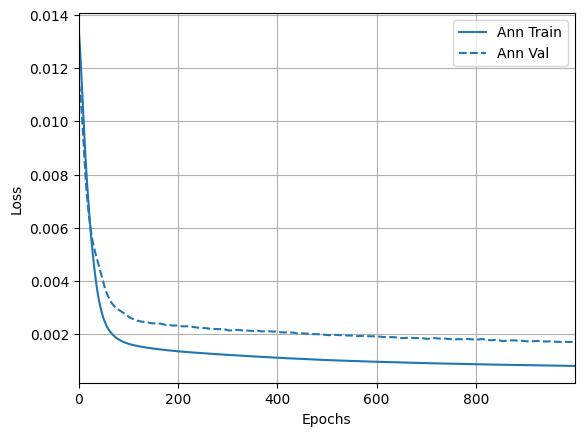

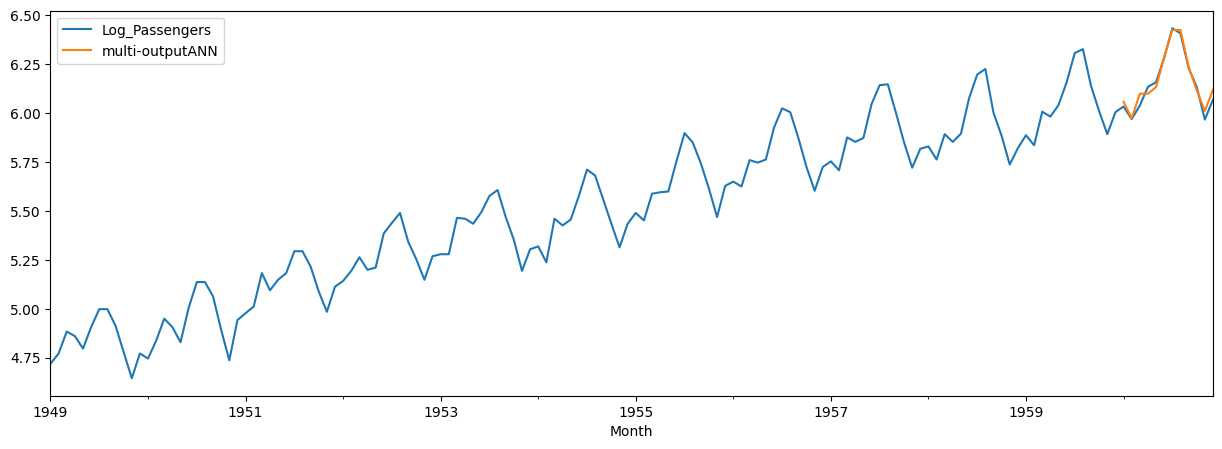

In [73]:
# DNets
history = {}
model = model_ann
name = 'ANN'
last_train = air_df.iloc[:-Ntest].iloc[-1]['Log_Passengers']

# instantiate call backs
check_point = ModelCheckpoint('best_model_'+name+'.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

# Compile Model
model = compile(model)

# Fit Model
history[name] = model.fit(X_train, y_train, epochs=1000, 
                    validation_data=(X_test, y_test),
                    callbacks=[check_point, early_stopping],
                    verbose=2)

# Get best model from current model
best_model = tf.keras.models.load_model('best_model_'+name+'.h5')

# Predict Output and de-differencing
X_test_pred = best_model.predict(X_test)
air_df.loc[test_idx, 'multi-output'+name] = last_train + np.cumsum(X_test_pred.flatten())

# Plot metric
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(history)

# plot 1-step forecast
air_df[['Log_Passengers', 'multi-outputANN']].plot(figsize=(15, 5));

In [75]:
y_true = air_df.loc[test_idx, 'Log_Passengers']
mape_ANN = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-outputANN'])
print('mape_ANN:', mape_ANN)

mape_ANN: 0.00401936721369017


# Using Deep Neural Networks Forecast - ANN, CNN, GRU and LSTM.

SINGLE OUTPUT/ MULTI-STEP FORECAST

In [78]:
# Build Models
# ANN - Seyi, note, ANN is comaptible with 2D data
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(K_s)(x)
model_ann = Model(i,x)

# CNN - 1D Conv
i = Input(shape=(T,D))
x = Conv1D(32, 3, activation='relu')(i)
x = MaxPool1D()(x)
x = Flatten()(x)
x = Dense(K_s)(x)
model_cnn = Model(i,x)

# GRU - Many to one
# By default, GRU and LSTM use tahn activation function, if you decide to use another activation function, it cannot be run on GPU
i = Input(shape=(T,D))
x = GRU(32)(i)
x = Dense(K_s)(x)
model_gru = Model(i,x)

# LSTM - Many to one with globalmaxpooling
i = Input(shape=(T,D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(K_s)(x)
model_lstm = Model(i,x)

CNN,GRU and LSTM for multi-step forecast.

In [101]:
# Data prep
airdf, X, Y = data_prep(air_df, T, D, Ntest, col_name='Passengers', 
                        difference=True, MNet=False, output_type='single')

# Train-test split (Single step, an extension can be multi-output-multi-step forecast)
X_train, y_train = X[:-Ntest], Y[:-Ntest]
X_test, y_test = X[-Ntest:], Y[-Ntest:]
print('X.shape', X.shape, 'Y.shape', Y.shape)
print("X_train.shape", X_train.shape, "Y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", y_test.shape)

X.shape (133, 10, 1) Y.shape (133,)
X_train.shape (121, 10, 1) Y_train.shape (121,)
X_test.shape (12, 10, 1) Y_test.shape (12,)


Compile and Fit Models - Multi-output (Input shape = NxTxD, Output shape = NxK)

In [87]:
# This is more concerned about making the right forecast and plotting it; i.e focus on X_test_pred
def multi_step_forecast_NN(df, model, Ntest, D, X_test, test_idx, col_name='Passengers', MNet=True):
  # Last-known train value
  last_train = df.iloc[:-Ntest].iloc[-1]['Log_'+col_name]

  # multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = X_test[0]

  while len(multistep_predictions) < Ntest:
    if MNet == True:
      p = model.predict(last_x.reshape(1, -1))[0]
    else:
      p = model.predict(last_x.reshape(1, -1, D))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # Make multi-step forecast and put in dataframe
  forecast = last_train + np.cumsum(multistep_predictions)

  return forecast

Epoch 1/1000
4/4 - 1s - loss: 9.3163e-04 - mean_absolute_percentage_error: 773622.3750 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 52.7504 - 924ms/epoch - 231ms/step
Epoch 2/1000
4/4 - 0s - loss: 8.9091e-04 - mean_absolute_percentage_error: 774520.3125 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 49.5983 - 58ms/epoch - 15ms/step
Epoch 3/1000
4/4 - 0s - loss: 8.1273e-04 - mean_absolute_percentage_error: 643132.3750 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 48.2817 - 58ms/epoch - 14ms/step
Epoch 4/1000
4/4 - 0s - loss: 8.3795e-04 - mean_absolute_percentage_error: 559817.8125 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 48.3836 - 59ms/epoch - 15ms/step
Epoch 5/1000
4/4 - 0s - loss: 8.3294e-04 - mean_absolute_percentage_error: 778776.8750 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 48.3424 - 46ms/epoch - 12ms/step
Epoch 6/1000
4/4 - 0s - loss: 8.1375e-04 - mean_absolute_percentage_error: 725381.3750 - val_loss: 0.0016 - val_m

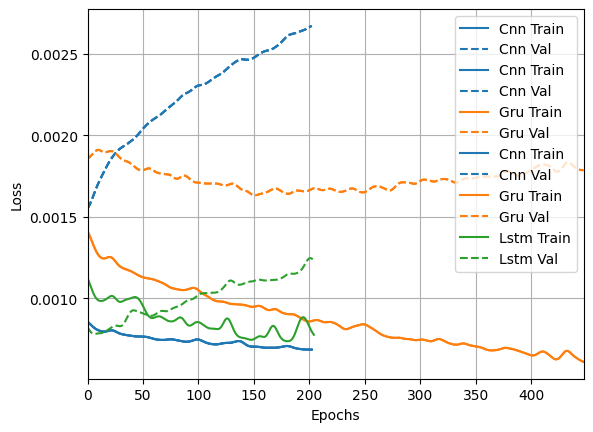

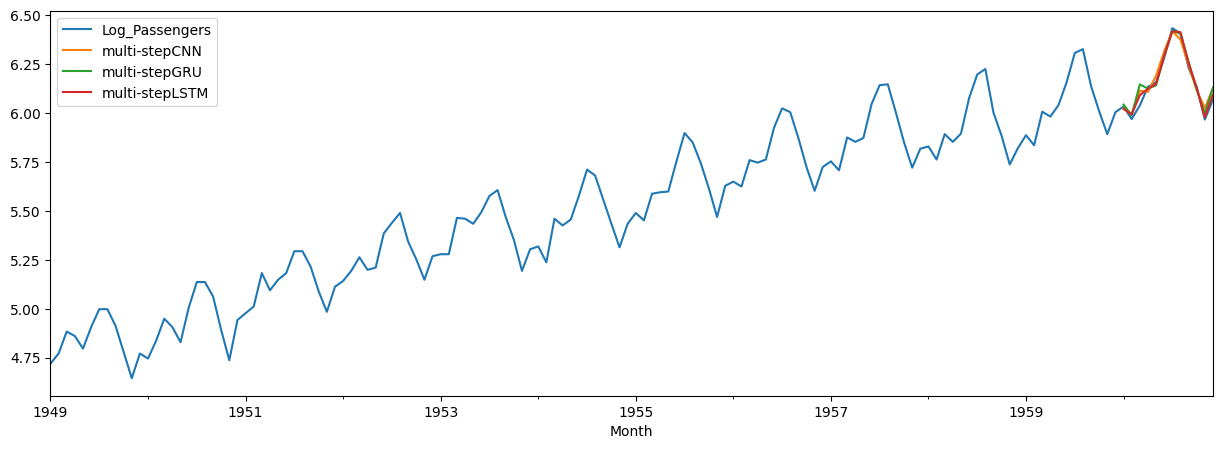

In [102]:
# DNets
history = {}
models = [model_cnn, model_gru, model_lstm]
names = ['CNN', 'GRU', 'LSTM']
last_train = air_df.iloc[:-Ntest].iloc[-1]['Log_Passengers']
for idx, name in enumerate(names):
  # instantiate call backs
  check_point = ModelCheckpoint('best_model_'+name+'.h5', monitor='val_loss', save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=200)

  # Compile Model
  model = compile(models[idx])

  # Fit Model
  history[name] = model.fit(X_train, y_train, epochs=1000, 
                      validation_data=(X_test, y_test),
                      callbacks=[check_point, early_stopping],
                      verbose=2)
  
  # Get best model from current model
  best_model = tf.keras.models.load_model('best_model_'+name+'.h5')

  # Predict Output and de-differencing
  forecast = multi_step_forecast_NN(air_df, best_model, Ntest, D, X_test, test_idx, col_name='Passengers', MNet=False)
  air_df.loc[test_idx,'multi-step'+name] = forecast

  # Plot metric
  plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
  plotter.plot(history)

# plot 1-step forecast
air_df[['Log_Passengers', 'multi-stepCNN', 'multi-stepGRU', 'multi-stepLSTM']].plot(figsize=(15, 5));

In [103]:
air_df.head()

,Passengers,Log_Passengers,Diff_Log_Passengers,multi-outputCNN,multi-outputGRU,multi-outputLSTM,multi-outputANN,multi-stepCNN,multi-stepGRU,multi-stepLSTM
Month,,,,,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,0.052186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,132,4.882802,0.112117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,129,4.859812,-0.022990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,121,4.795791,-0.064022,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2.   Let's compare the MAPE scores of all the networks/models to see the one that pperforms best.



In [104]:
y_true = air_df.loc[test_idx, 'Log_Passengers']
mape_CNN = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-stepCNN'])
print('mape_CNN:', mape_CNN)
mape_GRU = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-stepGRU'])
print('mape_GRU:', mape_GRU)
mape_LSTM = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-stepLSTM'])
print('mape_LSTM:', mape_LSTM)

mape_CNN: 0.005435827319313348
mape_GRU: 0.004445073573487005
mape_LSTM: 0.0027800882354106146


LSTM had the best result followed by GRU and CNN

Using Deep Neural Networks for multi-output forecast - ANN

In [105]:
# Data prep
airdf, X, Y = data_prep(air_df, T, D, Ntest, col_name='Passengers', 
                        difference=True, MNet=True, output_type='single')

# Train-test split (Single step, an extension can be multi-output-multi-step forecast)
X_train, y_train = X[:-Ntest], Y[:-Ntest]
X_test, y_test = X[-Ntest:], Y[-Ntest:]
print('X.shape', X.shape, 'Y.shape', Y.shape)
print("X_train.shape", X_train.shape, "Y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", y_test.shape)

X.shape (133, 10) Y.shape (133,)
X_train.shape (121, 10) Y_train.shape (121,)
X_test.shape (12, 10) Y_test.shape (12,)


Compile and Fit Models - Multi-output (Input shape = NxTxD, Output shape = NxK)

Epoch 1/1000
4/4 - 1s - loss: 0.0183 - mean_absolute_percentage_error: 2743166.5000 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 168.5704 - 817ms/epoch - 204ms/step
Epoch 2/1000
4/4 - 0s - loss: 0.0146 - mean_absolute_percentage_error: 2086064.8750 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 135.7798 - 87ms/epoch - 22ms/step
Epoch 3/1000
4/4 - 0s - loss: 0.0122 - mean_absolute_percentage_error: 1523609.3750 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 105.8287 - 55ms/epoch - 14ms/step
Epoch 4/1000
4/4 - 0s - loss: 0.0105 - mean_absolute_percentage_error: 1096261.5000 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 82.1151 - 56ms/epoch - 14ms/step
Epoch 5/1000
4/4 - 0s - loss: 0.0092 - mean_absolute_percentage_error: 973036.3125 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 65.7563 - 57ms/epoch - 14ms/step
Epoch 6/1000
4/4 - 0s - loss: 0.0085 - mean_absolute_percentage_error: 808804.5625 - val_loss: 0.0089 - val_mean_absolute_perc

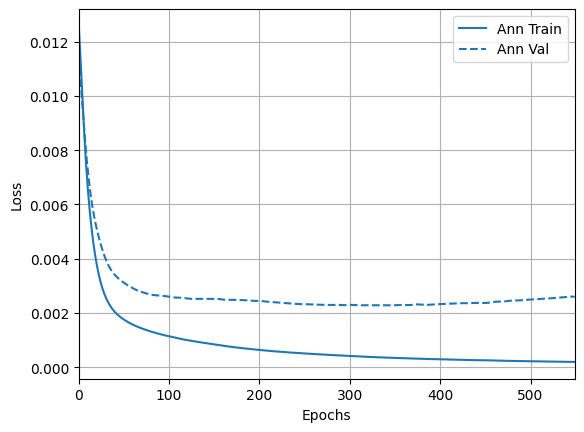

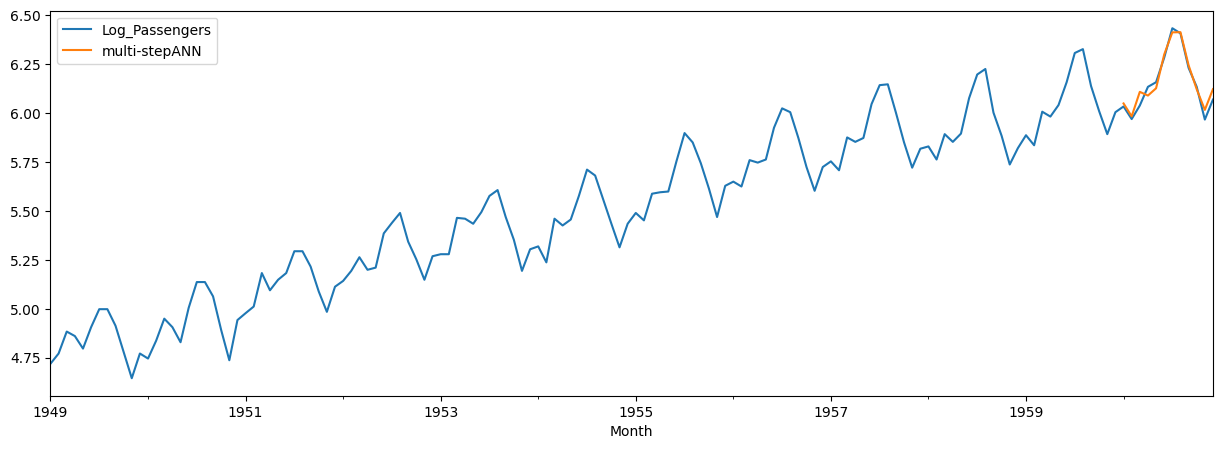

In [106]:
# DNets
history = {}
model = model_ann
name = 'ANN'

# instantiate call backs
check_point = ModelCheckpoint('best_model_'+name+'.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

# Compile Model
model = compile(model)

# Fit Model
history[name] = model.fit(X_train, y_train, epochs=1000, 
                    validation_data=(X_test, y_test),
                    callbacks=[check_point, early_stopping],
                    verbose=2)

# Get best model from current model
best_model = tf.keras.models.load_model('best_model_'+name+'.h5')

# Predict Output and de-differencing
forecast = multi_step_forecast_NN(air_df, best_model, Ntest, D, X_test, test_idx, col_name='Passengers', MNet=True)
air_df.loc[test_idx,'multi-step'+name] = forecast

# Plot metric
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(history)

# plot 1-step forecast
air_df[['Log_Passengers', 'multi-stepANN']].plot(figsize=(15, 5));

In [108]:
y_true = air_df.loc[test_idx, 'Log_Passengers']
mape_ANN = mean_absolute_percentage_error(y_true, air_df.loc[test_idx, 'multi-stepANN'])
print('mape_ANN:', mape_ANN)

mape_ANN: 0.004729239249022758


Conclusion/Comment: All the models worked pretty well. Below are the final MAPE results for all the models:



*   For single output/multi-step forecast


1.   [ANN, CNN, GRU, LSTM] : [0.004729239249022758, 0.005435827319313348,0.004445073573487005, 0.0027800882354106146]



*   For multi-output, single step forecast.



2.    [Linear regression, SVM, Random Forest] : [0.007109281288502536, 0.012149122102392764, 0.004731299904770553]


2.   [ANN, CNN, GRU, LSTM] : [0.00401936721369017, 0.0074370869437521735, 0.004156482848354078, 0.0036650270612509877]

